## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

### Code

In [21]:
import glob

import numpy as np
import scipy as sp
import scipy.io
import pandas as pd
from scipy.signal import find_peaks


def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.
    
    Review the README in ./datasets/troika/ to understand the organization 
    of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
            <data_fls> and <ref_fls> are ordered correspondingly, so that 
            ref_fls[5] is the reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls


def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]


def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and 
            corresponding reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse
            rate error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    # are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))


def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an 
        aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)


def RunPulseRateAlgorithm(data_fl, ref_fl):
    """
    Computation of pulse rate 

    Args:
        data_fl: Name of the .mat file that contain signal data
        ref_fl: Name of the .mat file that contain reference data

    Returns:
        Return mean absolute error from predicted pulse rate and reference and confidence as a 2-tuple of 
            numpy arrays.
    """
    # Load data using LoadTroikaDataFile
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    
    fs = 125
    # 8 seconds windows
    window = 8 * fs 
    # 6s Overlap btw windows
    overlap = 6 * fs 
    freq_min = 40/60
    freq_max = 240/60

    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    ref = sp.io.loadmat(ref_fl)
    
    # Compute pulse rate estimates and estimation confidence.
    errors = []
    confidence = []
    ref_hr = []
    computed_hr = []
    
    for window_num in range(len(ref['BPM0'])):
        refHR = ref['BPM0'][window_num][0]

        window_start = (window - overlap) * window_num
        window_end = window_start + window 

        ppg_win = ppg[window_start:window_end]
        ppg_bandpass = BandpassFilter(ppg_win, (freq_min, freq_max), fs=fs)

        accx_win = accx[window_start:window_end]
        accy_win = accy[window_start:window_end]
        accz_win = accz[window_start:window_end]
        
        accx_bandpass = BandpassFilter(accx_win, (freq_min, freq_max), fs=fs)
        accy_bandpass = BandpassFilter(accy_win, (freq_min, freq_max), fs=fs)
        accz_bandpass = BandpassFilter(accz_win, (freq_min, freq_max), fs=fs)

        acc_win = Aggregate_acc_signal(accx_bandpass, accy_bandpass, 
                                       accz_bandpass)
        acc_bandpass = BandpassFilter(acc_win, (freq_min, freq_max), fs=fs)

        fft_len = max(len(ppg_bandpass), 4096)
        freqs, fft_ppg = FFT_Transform(ppg_bandpass, fs, fft_len, 
                                       bands=(freq_min, freq_max))
        _, fft_acc = FFT_Transform(acc_bandpass, fs, fft_len, 
                                   bands=(freq_min, freq_max))

        pks_ppg = find_peaks(fft_ppg, height=50, distance=5)[0]
        pks_acc = find_peaks(fft_acc, height=30, distance=5)[0] 
        
        peak = Find_peak(freqs, fft_ppg, pks_ppg, fft_acc, 
                         pks_acc, acc_top_pks=15, win_size=0.15)

        result_freq = freqs[peak]
        conf = Compute_confidence(freqs, result_freq, fft_ppg, peak_window=0.2)

        ref_hr.append(refHR)
        computed_hr.append(result_freq * 60)
        
        error = abs(result_freq * 60 - refHR)
        errors.append(error)
        confidence.append(conf)

    # Average measurement for better aproximation
    mean_computed_hr = pd.Series(computed_hr) \
        .rolling(5, center=True, min_periods=1) \
        .mean().values
        
    errors_mean = np.abs(mean_computed_hr - ref_hr)
    confidence_mean = pd.Series(confidence) \
        .rolling(5, center=True, min_periods=1) \
        .mean().values
    
    # Return per-estimate mean absolute error and confidence as a 2-tuple of 
    # numpy arrays.
    return errors_mean, confidence_mean


def BandpassFilter(signal, bands, order=3, fs=125):
    """
    Bandpass filter the signal by given bands.

    Args:
        signal: input array of data to be filtered
        bands: range of frequencies (a length-2 sequence)
        order: Order of the bandpass filter
        fs: sampling frequency

    Returns:
        the filtered output
    """
    b, a = sp.signal.butter(order, bands, btype='bandpass', fs=fs)
    return sp.signal.filtfilt(b, a, signal)


def Aggregate_acc_signal(x, y, z):
    """
    Aggregated accelerometer data in a single signal 

    Args:
        x: accelerometer signal in x axis
        y: accelerometer signal in y axis
        z: accelerometer signal in z axis

    Returns:
        the aggregated signal
    """
    acc = np.sqrt(x**2 + y**2 + z**2)
    # acc = x + y + z
    return acc


def FFT_Transform(x, fs, fft_len, bands=None):
    """
    Compute FFT transform and return magnitud

    Args:
        x: signal in time domain
        fs: sampling frequency
        fft_len: length of FFT to compute
        bands: range of frequencies (a length-2 sequence) to keep

    Returns:
        Return FTT sampled frequencies and magnitudes
    """
    freqs = np.fft.rfftfreq(fft_len, 1/fs)
    ftt_mags = np.abs(np.fft.rfft(x, fft_len))
    
    if bands:
        band_freqs = (freqs >= bands[0]) & (freqs <= bands[1])
        freqs = freqs[band_freqs]
        ftt_mags = ftt_mags[band_freqs]
    
    return freqs, ftt_mags


def Find_peak(freqs, fft_ppg, pks_ppg, fft_acc, pks_acc, acc_top_pks=10, 
              win_size=0.15):
    """
    Compute index of best peak candidate for ppg signal in frequency domain. 
    Accelerometer signal is taken into account to remove peaks due to arm 
    movements. 

    Args:
        freqs: FTT sampling frequencies
        fft_ppg: Magnitude of FFT transform for ppg signal
        pks_ppg: Index of peaks candidates in 'fft_ppg'
        fft_acc: Magnitude of FFT transform for acc signal
        pks_acc: Index of peaks candidates in 'acc_ppg'
        acc_top_pks: Number of acc peaks candidates used in computation
        win_size: Frequency windows used for comparing ppg and acc frequencies

    Returns:
        Return peak candidate 
    """
    # Sort peaks by its magnitud
    pks_ppg_sorted = [y for _, y in sorted(zip(fft_ppg[pks_ppg], pks_ppg), 
                                           reverse=True)]

    pks_acc_sorted = [y for _, y in sorted(zip(fft_acc[pks_acc], pks_acc), 
                                           reverse=True)]

    # Select frequencies for N most important peaks
    freq_filter = freqs[pks_acc_sorted[:acc_top_pks]]
    
    peak = pks_ppg_sorted[0]
    for pk_ppg in pks_ppg_sorted:
        f_pk = freqs[pk_ppg] 
        
        if not list(filter(lambda x: (f_pk > x - win_size) and 
                           (f_pk < x + win_size), 
                           freq_filter)):
            peak = pk_ppg
            break
    
    return peak


def Compute_confidence(freqs, freq, fft_mag, peak_window=0.2):
    """
    Compute confidence of frequency computed by comparing power of frequency 
    with the rest 

    Args:
        freqs: FTT sampling frequencies
        freq: Given frequency
        fft_mag: Magnitude of FFT transform for ppg signal
        peak_window: Frequency windows over frequency 

    Returns:
        Return confidence
    """
    peak_freq_win = (freqs >= freq - peak_window) & \
        (freqs <= freq + peak_window)
    
    spectral_energy = np.square(fft_mag)
    energy_ratio = np.sum(spectral_energy[peak_freq_win]) / \
        np.sum(spectral_energy)
    
    return energy_ratio 

In [22]:
print("MAE:", Evaluate())

MAE: 14.8741080282


## Code for testing

In [62]:
import numpy as np
from matplotlib import pyplot as plt

files = LoadTroikaDataset()
file_idx = 0
file = files[0][file_idx]
ref_file = files[1][file_idx]
print('Load data')
print('File:', file, 'Ref:', ref_file)

#file = './datasets/troika/training_data/DATA_01_TYPE01.mat'
#ref_file = './datasets/troika/training_data/REF_01_TYPE01.mat'
ppg, accx, accy, accz = LoadTroikaDataFile(file)
#plt.clf()
#plt.figure(figsize=(12, 8))
#plt.plot(ppg[:5000])

Load data
File: ./datasets/troika/training_data/DATA_01_TYPE01.mat Ref: ./datasets/troika/training_data/REF_01_TYPE01.mat


Analysis of ACC data and aggregation


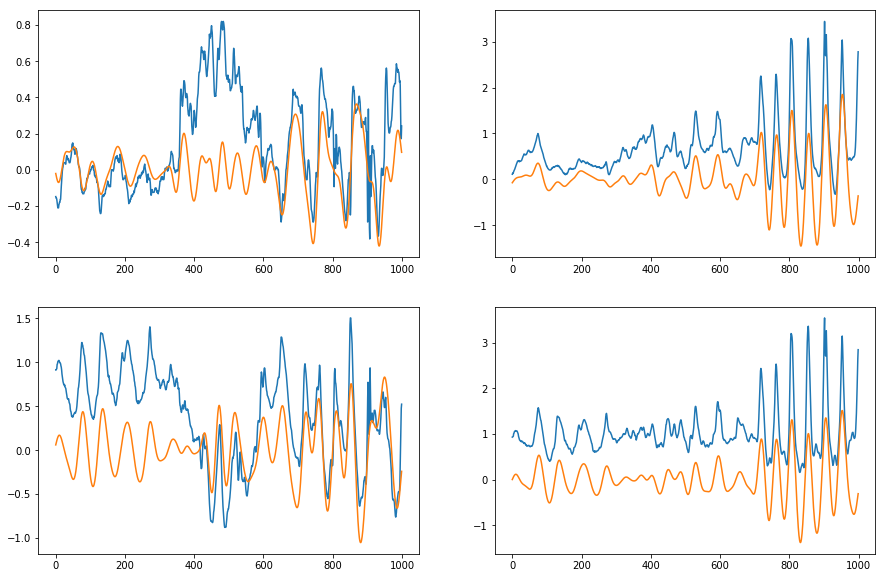

In [179]:
fs = 125
window = 8 * fs #8 seconds windows
overlap = 6 * fs #Overlap btw windows
freq_min = 40/60
freq_max = 240/60

window_num = 20

#Get Reference HR
ref = sp.io.loadmat(ref_file)
refHR = ref['BPM0'][window_num]

window_start = (window - overlap) * window_num
window_end = window_start + window 

ppg_win = ppg[window_start:window_end]
ppg_bandpass = BandpassFilter(ppg_win, (freq_min, freq_max), fs=fs)

#Count Peaks for HR Detection => too noisy
#pks = sp.signal.find_peaks(ppg_bandpass, height=10, distance=30)[0]
#plt.plot(pks/fs, ppg_bandpass[pks], 'r.', ms=10)

accx_win = accx[window_start:window_end]
accx_bandpass = BandpassFilter(accx_win, (freq_min, freq_max), fs=fs)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,10))
ax1.plot(accx_win)
ax1.plot(accx_bandpass)

accy_win = accy[window_start:window_end]
accy_bandpass = BandpassFilter(accy_win, (freq_min, freq_max), fs=fs)
ax2.plot(accy_win)
ax2.plot(accy_bandpass)

accz_win = accz[window_start:window_end]
accz_bandpass = BandpassFilter(accz_win, (freq_min, freq_max), fs=fs)
ax3.plot(accz_win)
ax3.plot(accz_bandpass)

print("Analysis of ACC data and aggregation")
acc_win = Aggregate_acc_signal(accx_win, accy_win, accz_win)
#acc_win = np.sqrt(accx_win**2 + accy_win**2 + accz_win**2)
#acc_win_sum = accx_win + accy_win + accz_win
acc_bandpass = BandpassFilter(acc_win, (freq_min, freq_max), fs=fs)
ax4.plot(acc_win)
ax4.plot(acc_bandpass)
plt.show()


Ref HR: [ 1.41083521] Bpm: [ 84.65011287]
Computed HR: 1.3427734375 Bpm: 80.56640625
Diff (bpm): [ 4.08370662]
Confidence: 0.163370143318


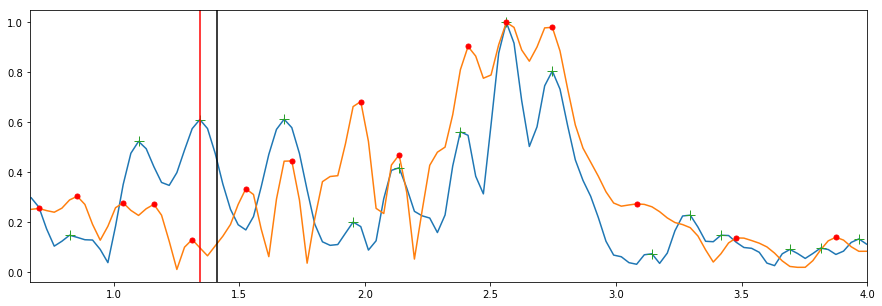

In [175]:
fft_len = max(len(ppg_bandpass), 4096)

freqs, fft_ppg = FFT_Transform(ppg_bandpass, fs, fft_len, bands=(freq_min, freq_max))
_, fft_acc = FFT_Transform(acc_bandpass, fs, fft_len, bands=(freq_min, freq_max))
    
pks_ppg = find_peaks(fft_ppg, height=50, distance=1)[0]
pks_acc = find_peaks(fft_acc, height=10)[0] #, distance=0.5
peak = Find_peak(freqs, fft_ppg, pks_ppg, fft_acc, pks_acc, acc_top_pks=6, win_size=0.2)

result_freq = freqs[peak]
confidence = Compute_confidence(freqs, result_freq, fft_ppg, peak_window=0.2)

print("Ref HR:", refHR / 60, "Bpm:", refHR)
print("Computed HR:", result_freq, "Bpm:", result_freq * 60)
print("Diff (bpm):", abs(result_freq * 60 - refHR))
print("Confidence:", confidence)

plt.figure(figsize=(15,5))
plt.legend()
plt.xlim(freq_min, freq_max)
plt.plot(freqs, fft_ppg/np.max(fft_ppg), label='FFT PPG')
plt.plot(freqs, fft_acc/np.max(fft_acc), label='FFT ACC')
plt.axvline(x=refHR/60, color='black', label='Ref HR')
plt.plot(freqs[pks_ppg], fft_ppg[pks_ppg]/np.max(fft_ppg), '+', ms=10)
plt.plot(freqs[pks_acc], fft_acc[pks_acc]/np.max(fft_acc), 'r.', ms=10)
plt.axvline(x=result_freq, color='red', label='Result HR')

-----
### Project Write-up

Answer the following prompts to demonstrate understanding of the algorithm you wrote for this specific context.

> - **Code Description** - Include details so someone unfamiliar with your project will know how to run your code and use your algorithm. 
> - **Data Description** - Describe the dataset that was used to train and test the algorithm. Include its short-comings and what data would be required to build a more complete dataset.
> - **Algorithhm Description** will include the following:
>   - how the algorithm works
>   - the specific aspects of the physiology that it takes advantage of
>   - a describtion of the algorithm outputs
>   - caveats on algorithm outputs 
>   - common failure modes
> - **Algorithm Performance** - Detail how performance was computed (eg. using cross-validation or train-test split) and what metrics were optimized for. Include error metrics that would be relevant to users of your algorithm. Caveat your performance numbers by acknowledging how generalizable they may or may not be on different datasets.

Your write-up goes here...

#### Code Description

The following algorithm is developed in Python. The algorithm calculates the heart rate from data obtained from a PPG sensor and an accelerometer sensor. 

Currently the algorithm is run on the Troika dataset, its format and structure is explained in more detail in the following section. To run the algorithm on the training samples of the dataset, you can run the Evaluate() function. This function iterates over each sample running the algorithm and finally obtaining the mean absolute error (MAE) over 90% of the samples with the highest confidence in the pulse rate calculation. 

On the other hand, if you wish to run the algorithm on an individual sample PPG signal, acceleration signal and a reference pulse signal, you have to prepare your data in the Troika dataset format. That is two files have to be prepared. The first file consists of the data obtained from the different sensors. The second file corresponds to the heart rate results obtained with other more reliable methods that will serve as a reference to evaluate the performance of the algorithm. Then the RunPulseRateAlgorithm() function receives the two data files as parameters and provides the estimated pulses value and its confidence for each 8 second sliding window of the signal.

#### Data Description

The dataset used by the algorithm is based on the Troika dataset. The dataset contains 12 samples of subjects between 18 and 35 years old. For each subject, its PPG signal obtained from the wrist and an acceleration signal based on a 3-axis accelerometer also placed on the wrist are obtained. Additionally, an ECG signal is stored which is not processed by the algorithms. All signals are collected at a frequency of 125Hz. The data recorded for each sample is obtained from subjects running on a treadmill for 5 minutes following these progressions: rest -> 6 / 8km/h -> 12 / 15km/h -> 6 / 8km/h -> 12 / 15km/h -> rest

In order to improve the performance of the algorithms, it would be desirable to increase the number of samples and to increase the variability of the samples, for example in the age of the subjects. Additionally, it would be desirable to know the physiological characteristics of the subjects to be taken into account in the algorithms.

#### Algorithhm Description

The algorithm aims to estimate heart rate from the PPG signal of subjects running in a treadmill. PPG sensors are the typical sensors for heart rate estimation during sport. For this purpose, the sensor is usually placed on the wrist. The (typically green) light emitted by the PPG sensor is absorbed by red blood cells in these capilaries and the photodetector will see the drop in reflected light. When the blood returns to the heart, fewer red blood cells in the wrist absorb the light and the photodetector sees an increase in reflected light. The period of this oscillating waveform is the pulse rate.

Unfortunatelly, the movements produced by the subject during sport induce perturbations that generate periodic signals on the PPG signal. Therefore, the objective is to analyse both signals to discriminate the perturbations generated by the movement in order to obtain a more accurate measurement.

For this purpose, the algorithm follows the following steps:
1. The signal is divided into windows of 8 seconds with an overlap of 6 seconds between them.
A band-pass filter is applied to all signals within the window to filter out frequencies outside the 40-240 BMP range.
2. The 3 signals obtained from the accelerometer (ACC) are aggregated into one signal by applying the modulus of the three signals. A bandpass filter is applied again on the signal.
3. The PPG signal and the aggregated ACC signal are frequency transformed by FFT and their magnitude is obtained.
4. The most predominant frequencies of each signal are obtained. The predominant frequency of PPG is analysed and it is compared that it does not coincide with any of the N (5) most predominant frequencies of ACC. If it coincides, it is discarded and the next one is continued. The first PPG frequency that does not overlap with those obtained from the ACC will be chosen as the candidate.
5. Then, the confidence value of the frequency obtained is obtained. To do this, the energy of the frequency obtained is obtained and compared with the rest of the frequencies within the range 40-240BMP.
6. Finally, for each of the windows obtained, a moving average is calculated to obtain a more accurate result.

The results obtained by the algorithm may not be accurate in some cases. Depending on the disturbances induced by the subject's motion, it is possible that periodic signals may not be generated directly and may not be detectable. Furthermore, the aggregation of the 3 acceleration axes simplifies the problem, but may reduce the periodic behaviour of the signal. 



#### Algorithm Performance
The performance of the algorithm is compared with the reference data provided for TROIKA dataset, which have been obtained from ECG data. As explained above, each sample is divided into sliding windows and the prediction and confidence is calculated for each window. The absolute error of each measurement with respect to the reference value is then obtained. For the errors obtained from all the samples, the 10% of the samples with the lowest confidence are discarded and the mean absolute error (MAE), i.e. the average of the values, is calculated. For the experiment performed abov, the mean absolute error (MAE) obtained is ~15 bpm.

Certain parameters of the algorithm can be adjusted to reduce the error metric obtained, but this may induce generalisation problems with other types of dataset. On the other hand, the calculation of the confidence depends on the disturbance generated by the movement and the signal to noise ratio, so it can be affected for example by sudden movements. As well as the swinging of the arms during running practice produces periodic signals as a basis for detecting these disturbances in the PPG signal. But unfortunately these peculiarities may not be consistent in other sports, e.g. tennis or boxing.


-----
### Next Steps
You will now go to **Test Your Algorithm** to apply a unit test to confirm that your algorithm met the success criteria. 